# Multiple bar chart showing the EU electricity production by source in 2023

## Get the data

Load the data into a [Pandas](https://pandas.pydata.org/) dataframe and filter by year.

In [316]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_ornaments.titles import set_title_and_subtitle

df = pd.read_csv('https://raw.githubusercontent.com/bianconif/graphic_communication_notebooks/refs/heads/master/data/eu-electricity-production.csv',comment='#')
df = df[df['Year'] == (year := 2023)]
print(df.head(10))

     Country  Year            Source  Value
207  Austria  2023         Bioenergy   4.56
208  Austria  2023              Coal   0.00
209  Austria  2023               Gas   7.50
210  Austria  2023             Hydro  40.67
211  Austria  2023           Nuclear   0.00
212  Austria  2023      Other Fossil   3.32
213  Austria  2023  Other Renewables   0.00
214  Austria  2023             Solar   6.39
215  Austria  2023              Wind   8.34
432  Belgium  2023         Bioenergy   3.80


Add the country codes (ISO 3166)

In [317]:
df_codes = pd.read_csv('https://raw.githubusercontent.com/bianconif/graphic_communication_notebooks/refs/heads/master/data/countries_iso3166b.csv', comment='#')
print(df_codes.head())

  iso2 iso3  iso_num         country  country_common
0   AF  AFG        4     Afghanistan     Afghanistan
1   AX  ALA      248   Aland Islands   Aland Islands
2   AL  ALB        8         Albania         Albania
3   DZ  DZA       12         Algeria         Algeria
4   AS  ASM       16  American Samoa  American Samoa


In [318]:
df = df.merge(df_codes[['country', 'iso3']], left_on='Country', right_on='country')
print(df.head(10))

   Country  Year            Source  Value  country iso3
0  Austria  2023         Bioenergy   4.56  Austria  AUT
1  Austria  2023              Coal   0.00  Austria  AUT
2  Austria  2023               Gas   7.50  Austria  AUT
3  Austria  2023             Hydro  40.67  Austria  AUT
4  Austria  2023           Nuclear   0.00  Austria  AUT
5  Austria  2023      Other Fossil   3.32  Austria  AUT
6  Austria  2023  Other Renewables   0.00  Austria  AUT
7  Austria  2023             Solar   6.39  Austria  AUT
8  Austria  2023              Wind   8.34  Austria  AUT
9  Belgium  2023         Bioenergy   3.80  Belgium  BEL


Aggregate the primary sources of electricity into the following groups: *fossil*, *nuclear*, *solar*, *wind*, *hydro* and *other renewables*.

In [319]:
aggregated_classes = {'Bioenergy': 'Other renewables', 'Coal': 'Fossil', 'Gas': 'Fossil', 'Hydro': 'Hydro',
                      'Nuclear': 'Nuclear', 'Other fossil': 'Fossil', 'Other Renewables': 'Other renewables',
                      'Solar': 'Solar', 'Wind': 'Wind'}
df['Source-aggregated'] = df['Source'].map(aggregated_classes)
print(df.head())

   Country  Year     Source  Value  country iso3 Source-aggregated
0  Austria  2023  Bioenergy   4.56  Austria  AUT  Other renewables
1  Austria  2023       Coal   0.00  Austria  AUT            Fossil
2  Austria  2023        Gas   7.50  Austria  AUT            Fossil
3  Austria  2023      Hydro  40.67  Austria  AUT             Hydro
4  Austria  2023    Nuclear   0.00  Austria  AUT           Nuclear


Aggregate the electricity production values by country and source.

In [320]:
df = df.groupby(by=['Country', 'iso3', 'Source-aggregated']).agg({'Value': 'sum'}).reset_index()
print(df.head(10))

   Country iso3 Source-aggregated  Value
0  Austria  AUT            Fossil   7.50
1  Austria  AUT             Hydro  40.67
2  Austria  AUT           Nuclear   0.00
3  Austria  AUT  Other renewables   4.56
4  Austria  AUT             Solar   6.39
5  Austria  AUT              Wind   8.34
6  Belgium  BEL            Fossil  18.30
7  Belgium  BEL             Hydro   0.41
8  Belgium  BEL           Nuclear  32.93
9  Belgium  BEL  Other renewables   3.80


Sort the countries by total electricity production in the selected year and retain the first `n_countries`.

In [321]:
#Sort the countries by total electricity production
df_total_by_country = df.groupby(by='Country').agg('sum').reset_index()
df_total_by_country = df_total_by_country.sort_values(by='Value', ascending=False)

#Retain the first n_countries
top_countries = df_total_by_country.iloc[0:(n_countries := 10)]['Country']
df = df[df['Country'].isin(top_countries)]

print(top_countries)

9      France
10    Germany
24      Spain
14      Italy
25     Sweden
19     Poland
1     Belgium
8     Finland
5     Czechia
0     Austria
Name: Country, dtype: object


## Create the multiple bar chart

### Define a colour palette

Define a qualitative colour palette for the electricity production sources. Use shades of red, blue and orange respectively for fossil, hydro, and solar; of green for other renewables. Palette generated with [ColorBrewer 2.0](https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=6).

In [322]:
palette = {'Fossil': '#e41a1c', 'Hydro': '#377eb8', 'Solar': '#ff7f00', 'Other renewables': '#4daf4a',
           'Nuclear': '#a65628', 'Wind': '#984ea3'}

### Create the chart

Create an empty figure (`fig`) with as many sub-plots (`axes`) as electricity sources using [Matplotlib's object oriented interface](https://matplotlib.org/stable/users/explain/figure/api_interfaces.html) [1]. Arrange the sub-plots into two columns. Iterate through the electricity sources and generate one bar chart for each of them [`matplotlib.axes.Axes.bar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar.html) method. Furthermore:
- Store the overall maximum value of power output by source for uniform scaling of the *y* axis across the sub-plots (`max_val`);
- Use the `hspace` parameter to define the vertical spacing between the sub-plots (values are in fraction of the average sub-plots height)

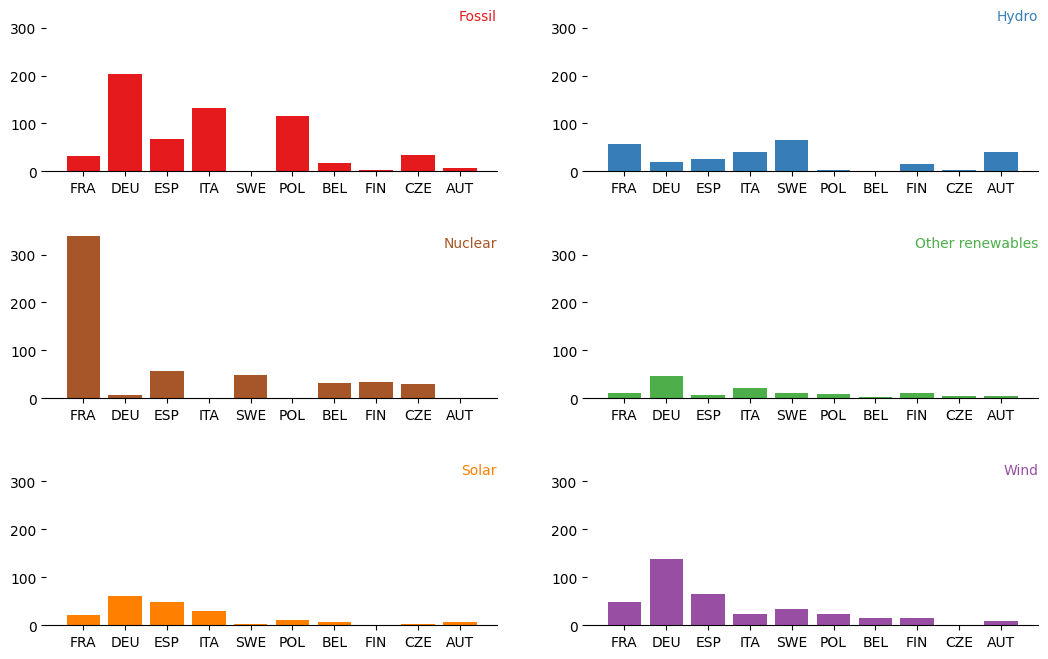

In [323]:
max_val = df['Value'].max()
grid_spec = {'hspace': 0.4}

n_cols = 2
n_rows = nrows=df.groupby(by='Source-aggregated').ngroups//n_cols

fig, axes = plt.subplots(n_rows, ncols=2, figsize=(12.8,8), gridspec_kw=grid_spec)
axes = axes.flatten()


for idx, (class_name, class_grp) in enumerate(df.groupby(by='Source-aggregated')):

    #Sort the bars from left to right by total electricity production in descending order
    class_grp = class_grp.set_index(keys='Country')
    class_grp = class_grp.loc[top_countries]
    class_grp = class_grp.reset_index()
    
    values = class_grp['Value'].to_numpy()

    #Create the stack for the current class of electricity source
    axes[idx].bar(x=class_grp['iso3'], height=values, label=class_name, facecolor=palette[class_name])

    #Apply uniform scale to the y axis
    axes[idx].set_ylim([0,max_val])

    #Despine
    axes[idx].spines[['top', 'right', 'left']].set_visible(False)

    #Add name of electricity source
    axes[idx].text(x=1.0, y=1.0, s=class_name, ha='right', va='top', color=palette[class_name],
                   transform=axes[idx].transAxes)
    

## Get the appearance right

### Add a horizontal grid

Use [matplotlib.axes.Axes.grid](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.grid.html) to add a horizontal grid and [Axes.set_axisbelow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.grid.html) to send the grid to the background (just comment out this call if you'd rather have the grid in the foreground).

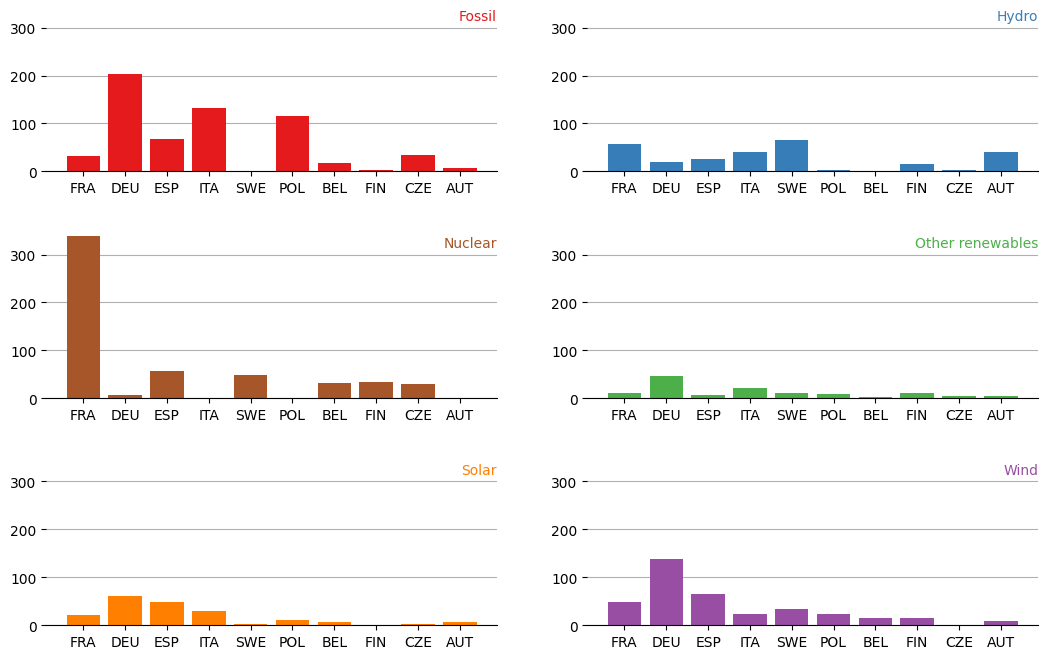

In [324]:
for ax in axes:
    ax.grid(visible=None, which='major', axis='y')
    ax.set_axisbelow(True)
display(fig)

### Add an icon to each sub-plot showing the energy source

Define an icon image for each energy source

In [325]:
base_folder = '../../../resources/images/'
icons = {'Fossil': 'fire-icon-01/fire-icon-01.png',
         'Hydro': 'waterfall-icon-00/waterfall-icon-00.png',
         'Nuclear': 'radioactive-icon-00/radioactive-icon-00.png',
         'Other renewables': 'renewable-energy-icon-00/renewable-energy-icon-00.png',
         'Solar': 'sun-icon-00/sun-icon-00.jpg',
         'Wind': 'wind-icon-01/wind-icon-01.png',
        }

Show the icon below the energy source label  

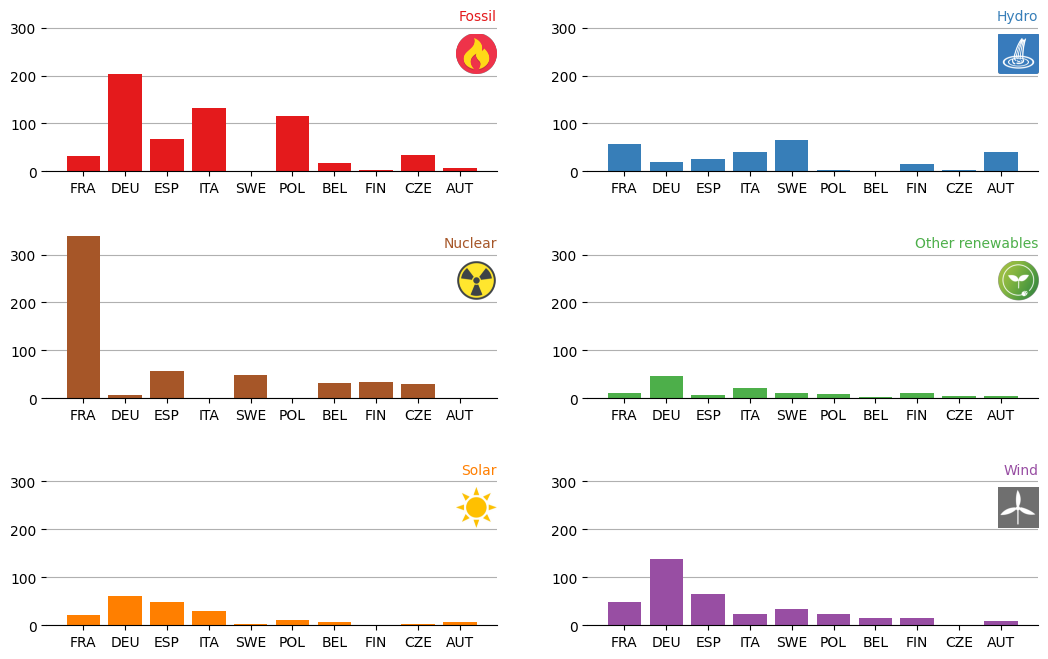

In [326]:
for idx, (class_name, _) in enumerate(df.groupby(by='Source-aggregated')):

    #Create an inset
    axin = axes[idx].inset_axes(bounds=(0.83, 0.6, 0.25, 0.25))

    #Load the icon 
    icon_img = plt.imread(f'{base_folder}/{icons[class_name]}')

    #Show the icon in the inset
    axin.imshow(icon_img)

    #Remove all inset decorations
    axin.set_axis_off()
display(fig)

### Add title and subtitle

Add a title and subtitle to the chart with [`mpl_ornaments.set_title_and_subtitle`](https://bianconif.github.io/mpl_ornaments/reference/).

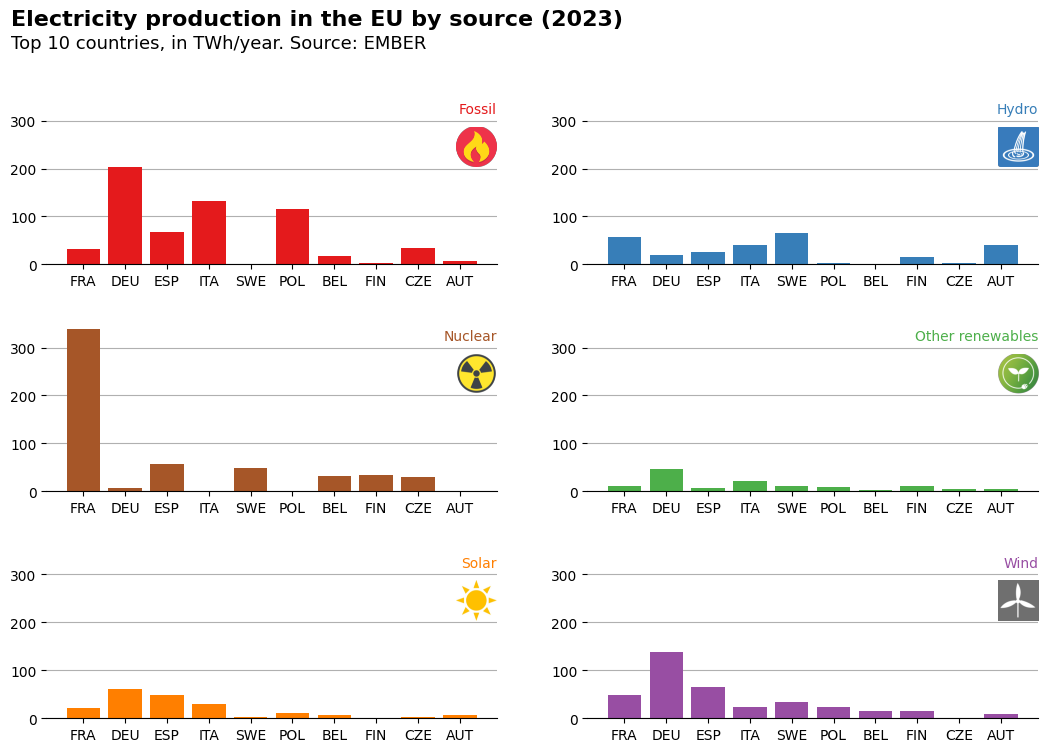

In [327]:
title = f'Electricity production in the EU by source ({year})'
subtitle = f'Top {n_countries} countries, in TWh/year. Source: EMBER'
set_title_and_subtitle(fig=fig, title=title, subtitle=subtitle, alignment='left', h_offset=90)
display(fig)

## References

[1] Bianconi F. [Data and process visualisation for graphic communication: A hands-on approach with Python](https://link.springer.com/book/10.1007/978-3-031-57051-3). Cham: Springer, 2024.

## Licence

Copyright © 2025 [Francesco Bianconi](https://www.bianconif.net/Home.html). All rights reserved.